In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform = transforms.Compose([
    # transforms.Resize(64),                 # Resize to 64x64 pixels
    # transforms.CenterCrop(64),             # Crop the center part of the image
    transforms.ToTensor(),                 # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [3]:
from datasets import load_dataset

# Create the dataset using ImageFolder
dataset = load_dataset('zh-plus/tiny-imagenet')

print(dataset)
print(dataset['train'].column_names)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
['image', 'label']


In [4]:
train_data = dataset['train']
train_data = train_data.shuffle(seed=42)

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235F4760>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CA680>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CB730>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CB7C0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CB850>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CB8E0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CB970>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CBA00>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CBA90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CA260>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CA2F0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x760A235CA380>, <PIL.JpegImagePlu

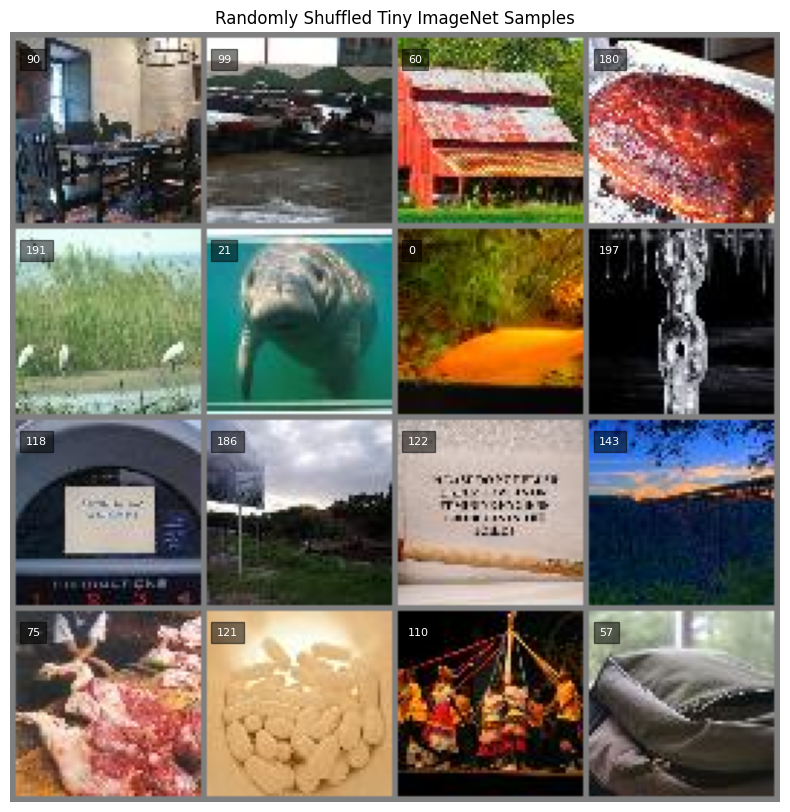

In [5]:
from PIL import Image

sample_data = train_data[:16]

print(sample_data)
print(type(sample_data))
# Extract images and labels
images = sample_data['image']  # This is already a list of PIL Images
labels = sample_data['label']  # This is already a list of labels

# Apply transformation to images and stack them into a batch
processed_images = [transform(img.convert("RGB")) for img in images]  # Convert to RGB and transform
image_tensor = torch.stack(processed_images)  # Stack into a batch of tensors

# Create a grid of images
grid_img = utils.make_grid(image_tensor, nrow=4, padding=2)  # Create a grid with 4 images per row

# Function to display the grid of images with corresponding labels
def show_grid(img_tensor, labels, title=None):
    # Convert tensor to numpy and adjust brightness
    np_img = img_tensor.numpy().transpose((1, 2, 0))  # Change to (H, W, C)
    np_img = np_img - np.min(np_img)  # Normalize to [0, 1] range
    np_img = np_img / np.max(np_img)  # Normalize to [0, 1] range
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')
    
    # Annotate labels
    num_images = len(labels)
    for i in range(num_images):
        x = (i % 4) * (64 + 2) + 5
        y = (i // 4) * (64 + 2) + 10
        plt.text(x, y, str(labels[i]), color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

    plt.show()

# Show the grid of images with a title and labels
show_grid(grid_img, labels, title="Randomly Shuffled Tiny ImageNet Samples")

Dataset class

In [7]:
class TinyImageNetDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data['image'])
    
    def __getitem__(self, idx):
        image = self.data['image'][idx].convert('RGB')  # Convert to RGB if not already
        if self.transform:
            image = self.transform(image)
        return image

In [8]:
tiny_imagenet_dataset = TinyImageNetDataset(train_data, transform=transform)
data_loader = DataLoader(tiny_imagenet_dataset, batch_size=64, shuffle=True)

In [9]:
for images in data_loader:
    # images is a batch of images ready for GAN training
    print(images.shape)  # Should output torch.Size([64, 3, 64, 64])
    break

torch.Size([64, 3, 64, 64])


GAN

In [11]:
# Generator class
class Generator(nn.Module):
    def __init__(self, noise_dim=100, image_channels=3, feature_g=64):
        """
        Generator for GAN
        :param noise_dim: Dimension of the input noise vector
        :param image_channels: Number of channels in the output image (e.g., 3 for RGB)
        :param feature_g: Base number of feature maps in the generator
        """
        super(Generator, self).__init__()

        # The Generator model uses transposed convolutions to upsample the input noise
        self.model = nn.Sequential(
            # First layer: Transform the noise vector into a feature map
            self._block(noise_dim, feature_g * 8, 4, 1, 0),  # (batch, 512, 4, 4)

            # Second layer: Upsample to 8x8
            self._block(feature_g * 8, feature_g * 4, 4, 2, 1),  # (batch, 256, 8, 8)

            # Third layer: Upsample to 16x16
            self._block(feature_g * 4, feature_g * 2, 4, 2, 1),  # (batch, 128, 16, 16)

            # Fourth layer: Upsample to 32x32
            self._block(feature_g * 2, feature_g, 4, 2, 1),  # (batch, 64, 32, 32)

            # Final layer: Upsample to 64x64 and produce the image
            nn.ConvTranspose2d(feature_g, image_channels, kernel_size=4, stride=2, padding=1),  # (batch, 3, 64, 64)
            nn.Tanh(),  # Output values in range [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        """
        Forward pass of the generator
        :param x: Input noise tensor of shape (batch_size, noise_dim, 1, 1)
        :return: Generated images of shape (batch_size, image_channels, 64, 64)
        """
        return self.model(x)
    

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, image_channels=3, feature_d=64):
        """
        Discriminator for GAN
        :param image_channels: Number of channels in the input image
        :param feature_d: Base number of feature maps in the discriminator
        """
        super(Discriminator, self).__init__()

        # The Discriminator model uses convolutions to downsample the input image
        self.model = nn.Sequential(

            # First layer: Downsample the image to 32x32
            nn.Conv2d(image_channels, feature_d, kernel_size=4, stride=2, padding=1),  # (batch, 64, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),

            # Second layer: Downsample to 16x16
            self._block(feature_d, feature_d * 2, 4, 2, 1),  # (batch, 128, 16, 16)

            # Third layer: Downsample to 8x8
            self._block(feature_d * 2, feature_d * 4, 4, 2, 1),  # (batch, 256, 8, 8)

            # Fourth layer: Downsample to 4x4
            self._block(feature_d * 4, feature_d * 8, 4, 2, 1),  # (batch, 512, 4, 4)

            # Final layer: Flatten and produce a single probability value
            nn.Conv2d(feature_d * 8, 1, kernel_size=4, stride=1, padding=0),  # (batch, 1, 1, 1)
            nn.Sigmoid(),  # Output is a probability between 0 and 1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        """
        Forward pass of the discriminator
        :param x: Input image tensor of shape (batch_size, image_channels, 64, 64)
        :return: Probability that the input images are real
        """
        return self.model(x).view(-1, 1)  # Flatten the output (batch_size, 1)

In [12]:
# Instantiate models
noise_dim = 100
generator = Generator(noise_dim=noise_dim)
discriminator = Discriminator()

# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

StyleGAN

In [13]:
# Mapping Network for StyleGAN
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=512, hidden_dim=512, num_layers=8):
        """
        Mapping Network for StyleGAN
        :param latent_dim: Dimension of the input latent vector
        :param hidden_dim: Dimension of hidden layers in the mapping network
        :param num_layers: Number of layers in the mapping network
        """
        super(MappingNetwork, self).__init__()

        # Create a sequential model with multiple fully connected layers
        layers = [nn.Linear(latent_dim, hidden_dim), nn.LeakyReLU(0.2)]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the mapping network
        :param x: Input latent vector of shape (batch_size, latent_dim)
        :return: Style vector of shape (batch_size, hidden_dim)
        """
        return self.model(x)
    

# Generator class for StyleGAN
class StyleGenerator(nn.Module):
    def __init__(self, latent_dim=512, image_channels=3):
        """
        Generator for StyleGAN
        :param latent_dim: Dimension of the input latent vector
        :param image_channels: Number of channels in the output image
        """
        super(StyleGenerator, self).__init__()

        # Mapping Network to convert latent vectors into style vectors
        self.mapping = MappingNetwork(latent_dim)

        # Constant input for the initial feature map
        self.const_input = nn.Parameter(torch.randn(1, 512, 4, 4))  

        # Upsample blocks to gradually increase the resolution of the generated images
        self.upsample_blocks = nn.ModuleList([
            self._block(512, 256),  # Upsampling 4x4 -> 8x8
            self._block(256, 128),  # Upsampling 8x8 -> 16x16
            self._block(128, 64),   # Upsampling 16x16 -> 32x32
            self._block(64, 32),    # Upsampling 32x32 -> 64x64
        ])

        # Final convolution to produce the RGB image
        self.to_rgb = nn.Conv2d(32, image_channels, kernel_size=1)

    def _block(self, in_channels, out_channels):
        """
        Helper function to create an upsampling block
        :param in_channels: Number of input channels
        :param out_channels: Number of output channels
        :return: Sequential upsampling block
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
        )

    def forward(self, z):
        """
        Forward pass of the generator
        :param z: Input latent vector of shape (batch_size, latent_dim)
        :return: Generated images of shape (batch_size, image_channels, 64, 64)
        """
        style = self.mapping(z) # Transform the latent vector into a style vector
        x = self.const_input.expand(z.size(0), -1, -1, -1) # Expand the constant input to match batch size
        
        # Apply each upsampling block
        for block in self.upsample_blocks:
            x = block(x)
        
        # Produce the final RGB image
        x = self.to_rgb(x)
        return torch.tanh(x)  # Normalize output to [-1, 1]


# Discriminator class for StyleGAN
class StyleDiscriminator(nn.Module):
    def __init__(self, image_channels=3):
        """
        Discriminator for StyleGAN
        :param image_channels: Number of channels in the input image
        """
        super(StyleDiscriminator, self).__init__()
        
        # Downsample blocks to gradually decrease the resolution of the input images
        self.downsample_blocks = nn.ModuleList([
            self._block(32, 64),    # Downsampling 64x64 -> 32x32
            self._block(64, 128),   # Downsampling 32x32 -> 16x16
            self._block(128, 256),  # Downsampling 16x16 -> 8x8
            self._block(256, 512),  # Downsampling 8x8 -> 4x4
        ])

        # Initial convolution to map input image to the desired channels
        self.from_rgb = nn.Conv2d(image_channels, 32, kernel_size=1)

        # Fully connected layer to produce the final output
        self.fc = nn.Linear(512 * 4 * 4, 1)

    def _block(self, in_channels, out_channels):
        """
        Helper function to create a downsampling block
        :param in_channels: Number of input channels
        :param out_channels: Number of output channels
        :return: Sequential downsampling block
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2), # Downsample by a factor of 2
        )

    def forward(self, x):
        """
        Forward pass of the discriminator
        :param x: Input image tensor of shape (batch_size, image_channels, 64, 64)
        :return: Probability that the input images are real
        """
        x = self.from_rgb(x) # Convert RGB input to feature map
        for block in self.downsample_blocks:
            x = block(x) # Appling each downsampling block
        x = x.view(x.size(0), -1)  # Flatten the output
        return self.fc(x) # Produce the final probability

In [14]:
# Instantiate models for StyleGAN
latent_dim = 512
style_generator = StyleGenerator(latent_dim=latent_dim)
style_discriminator = StyleDiscriminator()

# Define loss and optimizers for StyleGAN
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(style_generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(style_discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))